# Climate modes and diagnostics

We want to look at climate features during low energy events:
1. Daily events: solar and wind lulls. Pick out most spatially extensive lull-days (separate for each season, e.g. sum lulls over all regions, pick top 10% winter days.
    - daily circulation composites: MSLP, 500gph, 200gph. Do we get H/Ls in similar positions? What is the jet doing? Maybe a plot of wind vectors - nice to see the direction and speed?
2. Anomalous seasons: sum number of events over a season and look at the largest. Sub-question: do we get consecutive seasons with lots of regions experiencing events? This might go better in an earlier notebook.
    - modes of variability: SST, the variable used to calculate SAM. What do ENSO, IOD, SAM look like?
    
And, we want to do this the other way around. Do ENSO, IOD, SAM years lead us to energy lulls?

In [30]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [31]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '01:00:00'
cores = 8
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

In [32]:
cluster.scale(jobs=1)
client = Client(cluster)

In [33]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.41.72:8787/status,
Dashboard: http://10.6.41.72:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.41.72:39733,Workers: 0
Dashboard: http://10.6.41.72:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [34]:
# client.close()
# cluster.close()

In [35]:
# %load_ext autoreload
# %autoreload 2

In [7]:
# %reload_ext autoreload
# %autoreload 2

In [1]:
# import warnings

import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

In [2]:
import functions as fn

plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [72]:
years = range(1959, 2021)

data_fp = '/g/data/w42/dr6273/work/data/'

season_dict = fn.get_seasons()

# Load masks

In [4]:
rez_mask = fn.get_rez_mask()

# Load energy source and demand data

Sources: daily wind, daily solar and monthly runoff

In [5]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w']#.compute()

In [6]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd']#.compute()

In [7]:
rez_ro = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/ro_era5_monthly-averaged_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['ro']#.compute()

Annual runoff

In [8]:
rez_ro_ann = rez_ro.resample(time='1YS').sum()

Thresholds for event definitions

In [9]:
thresh_100w = rez_100w.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7
thresh_ro = rez_ro_ann.chunk({'time': -1}).quantile(0.25, ['time'])
thresh_t_cool = 15
thresh_t_warm = 21

### Events

In [36]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower').compute()

In [37]:
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower').compute()

In [38]:
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd).compute()

### Daily events over all regions

In [39]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

### Seasonal events over all regions

In [43]:
season_100w = fn.seasonal_mean(simul_100w)
season_mssrd = fn.seasonal_mean(simul_mssrd)
season_100w_mssrd = fn.seasonal_mean(simul_100w_mssrd)

# Load diagnostics and climate mode indices

### Daily diagnostics

500 hPa geopotential height

In [58]:
daily_z500_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/z/z_anoms_era5_daily_1400UTC_pl_1959-2020_extended_Aus_region.zarr',
    consolidated=True
)['z'].squeeze()

MSLP

In [22]:
daily_mslp = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_era5_daily_1400UTC_1959-2020_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

In [25]:
daily_mslp_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_anoms_era5_daily_1400UTC_1959-2020_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

### Monthly diagnostics and seasonal means

HadISST SST anomalies

In [22]:
sst_fp = data_fp + 'hadisst/sst/sst_anom_hadisst_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sst_anoms = xr.open_zarr(sst_fp, consolidated=True)
sst_anoms = fn.seasonal_mean(sst_anoms)

ERA5 MSLP anomalies

In [23]:
mslp_fp = data_fp + 'era5/mslp/mslp_anom_era5_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
mslp_anoms = xr.open_zarr(mslp_fp, consolidated=True)
mslp_anoms = fn.seasonal_mean(mslp_anoms)

### Climate mode indices

Nino3.4

In [24]:
nino34_fp = data_fp + 'hadisst/climate_modes/hadisst_nino34_'+str(years[0])+'-'+str(years[-1])+'.zarr'
nino34 = xr.open_zarr(nino34_fp, consolidated=True)
nino34 = fn.seasonal_mean(nino34)
nino34 = nino34.compute()

DMI

In [42]:
dmi_fp = data_fp + 'hadisst/climate_modes/hadisst_dmi_'+str(years[0])+'-'+str(years[-1])+'.zarr'
dmi = xr.open_zarr(dmi_fp, consolidated=True)
dmi = fn.seasonal_mean(dmi)
dmi = dmi.compute()

SAM

In [26]:
sam_fp = data_fp + 'era5/climate_modes/era5_sam_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sam = xr.open_zarr(sam_fp, consolidated=True)
sam = fn.seasonal_mean(sam)
sam = sam.compute()

# Daily diagnositcs on spatially extensive wind/solar/compound drought days

In [45]:
def get_spatial_events(da, season, q, time_name='time'):
    """
    Subsample the time steps which are spatially compounding,
    defined as when the number of regions experiencing an event
    exceeds a quantile threshold (q). Can be done by season.
    """
    months = fn.get_seasons()[season] # months in this season
    subset_da = fn.month_subset(da, months, time_name) # select data in this season
    thresh = subset_da.quantile(q, time_name) # top q extensive events
    events = subset_da.where(subset_da > thresh)
    years = events.dropna(time_name)[time_name].dt.year.values
    return years, events

In [56]:
def subset_on_events(event_da, diag_da, season, q, time_name='time'):
    """
    Obtain the diagnostic variable array over event years.
    """
    years, events = get_spatial_events(event_da, season, q, time_name)
    diag = fn.month_subset(diag_da, fn.get_seasons()[season])
    return years, events, diag

In [57]:
def composite_data(event_da, diag_da, season, q, time_name='time'):
    """
    Obtain the diagnostic variable array to be composited over event years.
    """
    years, events, diag = subset_on_events(event_da, diag_da, season, q, time_name)
    return years, diag.where(events.notnull()).mean(time_name)

In [74]:
thresh_spatial = 0.95 # top 5 % spatially extensive days

In [75]:
y, d = composite_data(simul_mssrd, daily_mslp_anoms, 'Winter', thresh_spatial)

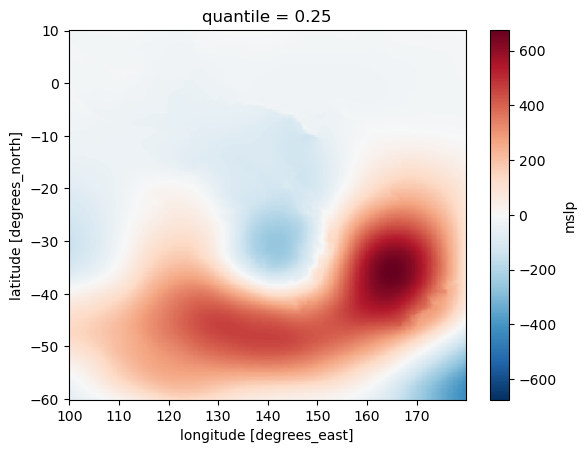

In [76]:
d.plot()

In [77]:
# mslp anoms roughly ±700
# mslp ful field 98000 to 110000?
# z500 anoms ±700

In [84]:
def plot_z_mslp(ax, z_da, mslp_da, years, mslp_anoms=False):
    """
    Plot geopotential height shading and MSLP contours on an axis.
    MSLP can be either full field or anomalies.
    """
    print(z_da.min().values, z_da.max().values)
    print(mslp_da.min().values, mslp_da.max().values)
    print()
    
    if mslp_anoms:
        m = 1000
        mslp_levels = np.arange(-m, m+1, 100)
        mslp_levels = [i for i in mslp_levels if i != 0]
    else:
        mslp_levels = np.arange(97800, 103000, 400)
    
    ax.coastlines(linewidths=0.1)
    
    p = p_z.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-700,
        vmax=700,
        cmap='RdBu_r',
        add_colorbar=False
    )
    p_mslp.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.4
    )
    
    ax.set_title('', fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    return p

-577.43286 696.30536
98166.25 102323.375

-209.27328 607.07526
98120.016 102346.86

-276.57547 593.3729
98185.68 102353.93

-577.6117 462.67026
97922.6 102269.11

-196.34154 484.53156
98083.18 102166.41

-287.1231 461.24188
98006.11 102157.945

-368.02377 512.0107
98560.83 101975.445

-580.3225 161.72845
98543.71 101961.65

-273.8264 550.2244
98566.875 101973.0

-479.0169 452.72617
98310.97 102067.51

-384.30576 612.1298
98172.88 102029.805

-305.52872 606.5384
98337.84 102144.414



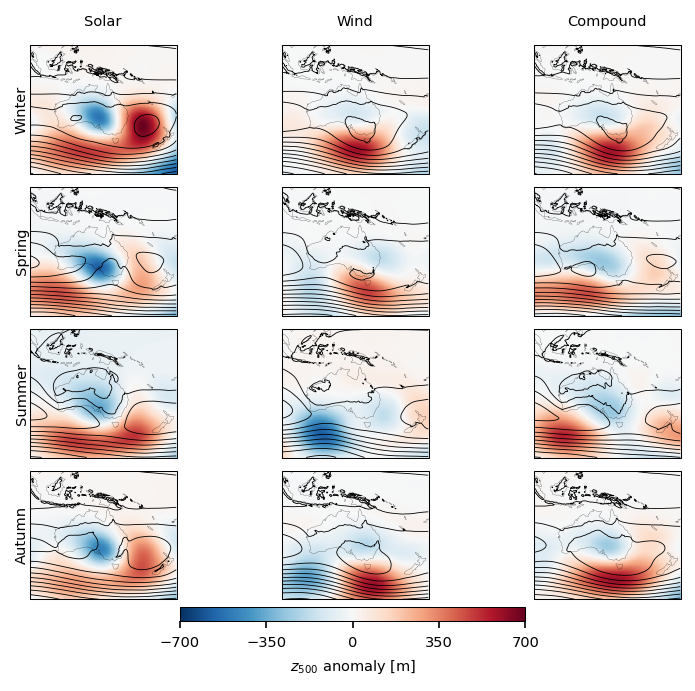

In [85]:
with plt.rc_context(plt_params):
    fig = plt.figure(dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180)))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for var in [simul_mssrd, simul_100w, simul_100w_mssrd]:
            years, p_z = composite_data(
                var,
                daily_z500_anoms,
                season,
                thresh_spatial
            )

            _, p_mslp = composite_data(
                var,
                daily_mslp,
                season,
                thresh_spatial
            )

            ax = axes[i]
            p = plot_z_mslp(ax, p_z, p_mslp, years)
            
            i += 1
                        
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    
    axes[0].text(0.5, 1.15, 'Solar', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.15, 'Wind', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.15, 'Compound', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    cb_ax1 = fig.add_axes([0.33, 0.08, 0.36, 0.02])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=np.arange(-700, 701, 350))
    cb1.ax.set_xlabel(r'$z_{500}$ anomaly [m]')

In [87]:
daily_z500

<xarray.DataArray 'z' (time: 22646, lat: 281, lon: 320)>
dask.array<getitem, shape=(22646, 281, 320), dtype=float32, chunksize=(365, 281, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 10.0 9.75 9.5 9.25 9.0 ... -59.25 -59.5 -59.75 -60.0
    level    int32 500
  * lon      (lon) float32 100.0 100.2 100.5 100.8 ... 179.0 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1959-01-01T14:00:00 ... 2020-12-31T14:00:00
Attributes:
    long_name:      Geopotential
    standard_name:  geopotential
    units:          m**2 s**-2

# Monthly diagnostics on spatially extensive wind/solar/compound drought years

Figure ideas:
1. PDFs of climate mode indices, with spatially compounding months/seasons marked (crosses, lines) or the composite mean marked.
2. Composite maps of SST and MSLP (plus some other variables eventually?) over spatially compounding months/seasons. Could also show which regions have events here - maybe counts/percentage of times each region is counted.

Should be done separately for each season.

In [30]:
def plot_sst_mslp(ax, sst_da, mslp_da, years):
    """
    Plot SST shading and MSLP contours on an axis.
    """
    m = 5000
    mslp_levels = np.arange(-m, m+1, 100)
    mslp_levels = [i for i in mslp_levels if i != 0]
    
    ax.coastlines(linewidths=0.1)
    
    p = p_sst.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-1.8,
        vmax=1.8,
        cmap='RdBu_r',
        # cbar_kwargs={
        #     'location': 'bottom',
        # },
        add_colorbar=False
    )
    p_mslp.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.4
    )
    
    format_years = [str(i) for i in years]
    title = ', '.join(format_years)
    ax.set_title(title, fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    return p

### Set variables

In [32]:
thresh_spatial = 0.9

### Composite maps

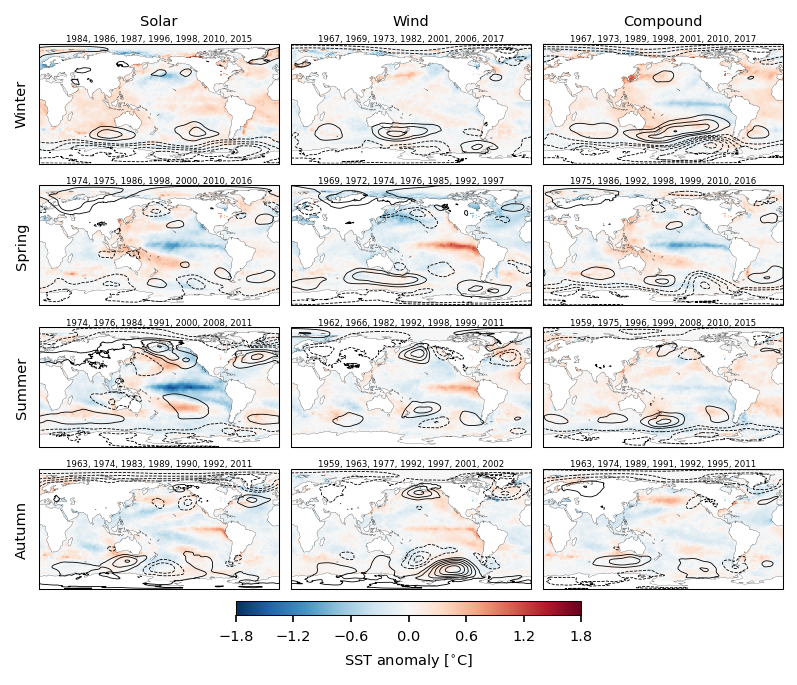

In [34]:
with plt.rc_context(plt_params):
    fig = plt.figure(dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180)))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for var in [season_mssrd, season_100w, season_100w_mssrd]:
            years, p_sst = composite_data(
                var,
                sst_anoms['sst_anom'],
                season,
                thresh_spatial
            )

            _, p_mslp = composite_data(
                var,
                mslp_anoms['mslp_anom'],
                season,
                thresh_spatial
            )

            ax = axes[i]
            p = plot_sst_mslp(ax, p_sst, p_mslp, years)
            
            i += 1
                        
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    
    axes[0].text(0.5, 1.15, 'Solar', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.15, 'Wind', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.15, 'Compound', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    cb_ax1 = fig.add_axes([0.33, 0.08, 0.36, 0.02])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=np.arange(-1.8, 1.9, 0.6))
    cb1.ax.set_xlabel(r'SST anomaly [$^{\circ}$C]')

### Climate modes PDFS

In [156]:
def mode_hist(ax, event_da_list, diag_da, season, q, xmin=-2.5, xmax=2.5, time_name='time'):
    """
    Get the histogram of diag_da for the season, and the individual
    points for values of diag_da on event years for each event in
    event_da_list.
    """
    event_values = []
    # Loop through event_da_list (usually wind, solar and compound)
    #  values will be different each time, but diag will be the same
    #  as it is just the seasonal distribution.
    for i, event_da in enumerate(event_da_list):
        years, events, diag = subset_on_events(event_da, diag_da, season, q, time_name)
        event_values.append(diag.where(events.notnull()).dropna(time_name).values)

    # Histogram
    b = np.linspace(xmin, xmax, 10)
    bins, hist = fn.hist_data(diag, b)
    
    ax.plot(bins, hist, color='k', lw=0.5)
    ax.fill_between(bins, 0, hist, color='k', alpha=0.15)
    
    # +- 1.5 standard deviations
    std = diag_da.std(time_name).values
    ax.axvline(std * 1.5, ls='--', lw=0.5, color='k')
    ax.axvline(std * -1.5, ls='--', lw=0.5, color='k')
    
    # Get ymax rounded up
    ymax = fn.round_decimals_up(np.max(hist), 1)
    # Use this to set y location of markers
    central_y = ymax / 9
    lower_y = central_y / 2.3
    upper_y = central_y * 1.8
    
    for values, y, marker, color, label in zip(
        event_values,
        [lower_y, central_y, upper_y],
        ['*', 'x', '.'],
        [colors[1], colors[0], colors[4]],
        ['Solar', 'Wind', 'Compound']
    ):
        s = ax.scatter(values, np.repeat(y, len(values)), color=color, marker=marker, s=10, lw=0.5, label=label)
        
    ax.set_xlim(xmin, xmax)
    
    # yticks (surely a better way exists...)
    if ymax > 1:
        ax.set_yticks(np.arange(0, 1.9, 0.6))
    elif (ymax <= 1) & (ymax > 0.8):
        ax.set_yticks(np.arange(0, 1.1, 0.5))
    elif (ymax <= 0.8) & (ymax > 0.5):
        ax.set_yticks(np.arange(0, 0.81, 0.4))
    else:
        ax.set_yticks(np.arange(0, 0.5, 0.2))
        
    return s

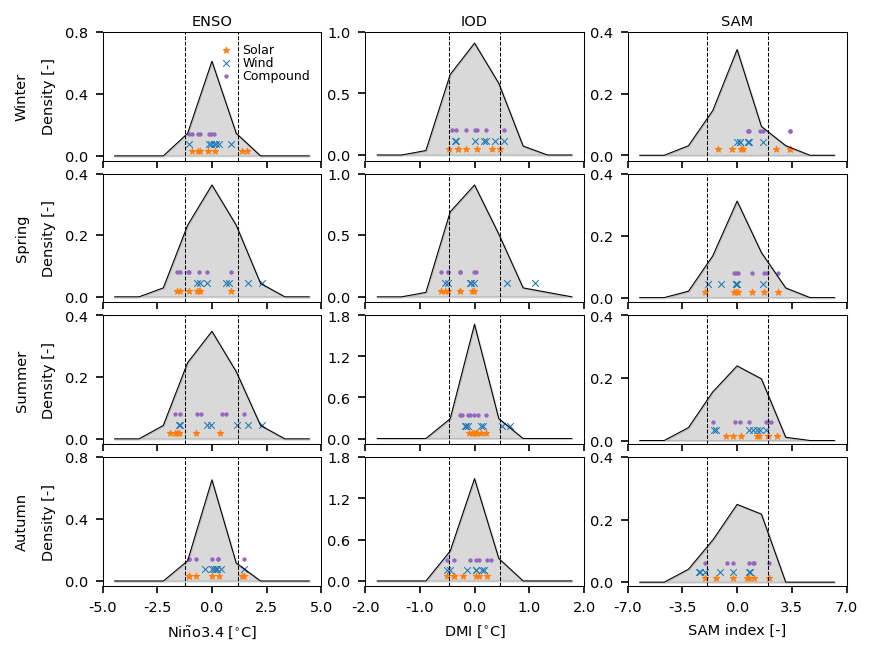

In [157]:
with plt.rc_context(plt_params):
    fig = plt.figure(dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for mode, xmin, xmax in zip(
            [nino34['nino34'], dmi['dmi'], sam['sam']],
            [-5, -2, -7],
            [5, 2, 7]
        ):
            
            ax = axes[i]
            s = mode_hist(
                ax,
                [season_mssrd, season_100w, season_100w_mssrd],
                mode,
                season,
                thresh_spatial,
                xmin,
                xmax
            )
            
            i += 1
            
    plt.subplots_adjust(hspace=0.1, wspace=0.2)
    
    axes[0].text(0.5, 1.05, 'ENSO', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.05, 'IOD', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.05, 'SAM', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.4, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.4, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.4, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.4, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    # ENSO xticks (and y labels)
    for i in [0, 3, 6, 9]:
        axes[i].set_xticks(np.arange(-5, 5.1, 2.5))
        axes[i].set_xticklabels('')
        axes[i].set_ylabel('Density [-]')
    axes[9].set_xticklabels(np.arange(-5, 5.1, 2.5))
    
    # IOD xticks
    for i in [1, 4, 7, 10]:
        axes[i].set_xticks(np.arange(-2, 2.1, 1))
        axes[i].set_xticklabels('')
    axes[10].set_xticklabels(np.arange(-2, 2.1, 1))
    
    # SAM xticks
    for i in [2, 5, 8, 11]:
        axes[i].set_xticks(np.arange(-7, 7.1, 3.5))
        axes[i].set_xticklabels('')
    axes[11].set_xticklabels(np.arange(-7, 7.1, 3.5))
    
    # xlabels
    axes[9].set_xlabel(r'Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]')
    axes[10].set_xlabel(r'DMI [$^{\circ}$C]')
    axes[11].set_xlabel('SAM index [-]')
    
    # legend
    axes[0].legend(frameon=False, loc='upper right')

# Close cluster

In [62]:
client.close()
cluster.close()